In [1]:
import torch
from transformers import AutoTokenizer, AutoModel
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score, precision_score, recall_score, mean_absolute_error, confusion_matrix, ConfusionMatrixDisplay, mean_squared_error
import tensorflow.keras as keras
from IPython.display import display
tf.keras.utils.set_random_seed(42)  # sets seeds for base-python, numpy and tf
tf.config.experimental.enable_op_determinism()

In [2]:
df_c19 = pd.read_csv("final_datasets/c19_final_2.csv")
df_m17 = pd.read_csv("final_datasets/m17_final_2.csv")
df_c19 = df_c19.sample(n=len(df_c19), random_state=42)
df_m17 = df_m17.sample(n=len(df_m17), random_state=42)

In [3]:
# Load the SciBERT model and tokenizer
model_name = 'allenai/scibert_scivocab_uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


def get_sentence_embeddings(sentences):
    inputs = tokenizer(sentences, return_tensors='pt', padding=True, truncation=True, max_length=512)
    inputs = {key: value.to(device) for key, value in inputs.items()}  # Move inputs to GPU
    with torch.no_grad():
        outputs = model(**inputs)
    embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()  # Move embeddings back to CPU
    return embeddings

# Apply the function to the sentences column
df_c19['embeddings'] = df_c19['abstract'].apply(lambda x: get_sentence_embeddings([x])[0])
df_m17['embeddings'] = df_m17['abstract'].apply(lambda x: get_sentence_embeddings([x])[0])

print(df_c19.head())

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.


                                                  title  \
1376       Poikilosis - pervasive biological variation.   
932   PI3Kδ Inhibition as a Potential Therapeutic Ta...   
144   Disinfection of Wastewater by UV-Based Treatme...   
1752  Targeting Toll-Like Receptors: Promising Thera...   
51    Exploring values among three cultures from a g...   

                                               abstract  cited   rigor  \
1376  Biological systems are dynamic and display het...      0  medium   
932   The spread of the novel human respiratory coro...      0    high   
144   Among the critical issues that prevent the reu...      0    high   
1752  Toll-like receptors (TLRs) are pattern recogni...      1    high   
51    The United Nations Educational, Scientific and...      0  medium   

     novelty  grammar  replicability accessibility  mathematics  \
1376    high        0              0          high          0.0   
932     high        0              1          high          0.0   

In [4]:
df_c19['embeddings'][0]

array([-5.61440662e-02,  3.09928767e-02, -3.34812850e-01,  8.84458274e-02,
       -3.23522478e-01, -4.01779830e-01, -6.27285480e-01, -1.21436492e-01,
       -2.72875130e-01, -3.86441976e-01,  1.19689822e+00, -7.87408799e-02,
       -1.89626217e-01,  8.80436897e-01, -7.27966607e-01,  4.23540145e-01,
       -1.83934104e+00, -2.31000125e-01, -9.04320478e-01, -1.25017059e+00,
        6.82431102e-01,  3.23260427e-01, -2.65808463e-01, -4.51900989e-01,
        2.36306638e-01,  4.50663269e-01, -2.06705153e-01, -1.50621176e-01,
        2.58470029e-01,  3.36903274e-01, -7.14306056e-01, -3.13218892e-01,
       -8.55109632e-01, -6.39696896e-01, -5.94773352e-01, -5.02607405e-01,
        1.03738189e+00, -3.39862369e-02,  6.16290331e-01,  4.30794895e-01,
       -3.53206605e-01,  1.74151301e+00,  1.67029992e-01, -3.61102492e-01,
        6.39657736e-01,  3.16981941e-01,  1.21461570e+00,  4.14001673e-01,
        5.82800210e-01, -1.47189930e-01,  7.16373146e-01, -2.58889824e-01,
        9.10117209e-01,  

In [4]:
def get_train_test(df):
    df.drop(['title', 'abstract', 'science_field', 'collaborators', 'journal_name'], axis = 1, inplace= True, errors='ignore')
    # df_c19[['rigor', 'novelty', 'accessibility']] = df_c19[['rigor', 'novelty', 'accessibility']].astype('category')
    # enc = OrdinalEncoder(categories=[['low', 'medium', 'high']])
    # df['rigor'] = enc.fit_transform(df[['rigor']])
    # df['novelty'] = enc.fit_transform(df[['novelty']])
    # df['accessibility'] = enc.fit_transform(df[['accessibility']])
    if 'evaluation' in df.columns:
        y  = df['evaluation']
        X =  df.drop(['evaluation', 'eval_reduced'], axis=1)
    else:
        y  = df['cited']
        X =  df.drop(['cited'], axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return  X_train, X_test, y_train, y_test

In [5]:
def get_conf_matrix(y_test, y_pred):
    intensity = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix = intensity, display_labels=set(y_test))
    disp.plot()

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 128)         │       459,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 515,713 (1.97 MB)

 Trainable params: 515,329 (1.97 MB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5535 - loss: 0.7528 - val_accuracy: 0.5833 - val_loss: 0.6904
Epoch 2/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5879 - loss: 0.7042 - val_accuracy: 0.5625 - val_loss: 0.6866
Epoch 3/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6220 - loss: 0.6515 - val_accuracy: 0.5833 - val_loss: 0.6734
Epoch 4/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6501 - loss: 0.6319 - val_accuracy: 0.6083 - val_loss: 0.6642
Epoch 5/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6524 - loss: 0.6406 - val_accuracy: 0.6000 - val_loss: 0.6533
Epoch 6/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6579 - loss: 0.6153 - val_accuracy: 0.6125 - val_loss: 0.6531
Epoch 7/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6787 - loss: 0.6106 - val_accuracy: 0.6000 - val_loss: 0.6543
Epoch 8/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6891 - loss: 0.5920 - val_accuracy: 0.6375 - val_loss:

'LSTM with SciBERT embeddings Accuracy score: 0.6166666666666667'

'LSTM with SciBERT embeddings Recall score: 0.6158107701396707'

'LSTM with SciBERT embeddings F1 score: 0.6157059314954052'

'LSTM with SciBERT embeddings Precision score: 0.6156560652781333'

'LSTM with SciBERT embeddings MAE score: 0.38333333333333336'

'Multimodal Predictor MSE score: 0.38333333333333336'

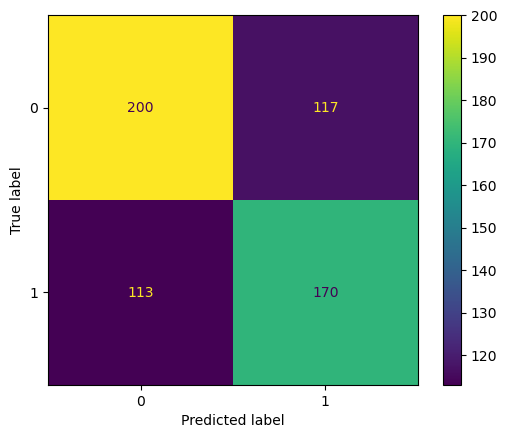

In [6]:
# Prepare data for LSTM model
X = np.stack(df_c19['embeddings'].values)
y = df_c19['cited'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape data to fit LSTM input requirements
X_train = np.expand_dims(X_train, axis=1)  # Add a time dimension
X_test = np.expand_dims(X_test, axis=1)

# Build the expanded LSTM model
model = Sequential()

# First LSTM layer with Batch Normalization
model.add(LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Second LSTM layer
model.add(LSTM(64, return_sequences=False))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Dense layers
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))  # Assuming binary classification

model.compile(loss='binary_crossentropy', optimizer='adamw', metrics=['accuracy'])
model.summary()
callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, min_delta=0.002, restore_best_weights=True),
]
# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1, callbacks=callbacks)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

# Make predictions
y_pred = (model.predict(X_test) > 0.5).astype("int32")
display(f"LSTM with SciBERT embeddings Accuracy score: {accuracy_score(y_test, y_pred)}")
display(f"LSTM with SciBERT embeddings Recall score: {recall_score(y_test, y_pred, average='macro')}")
display(f"LSTM with SciBERT embeddings F1 score: {f1_score(y_test,  y_pred, average='macro')}")
display(f"LSTM with SciBERT embeddings Precision score: {precision_score(y_test, y_pred, average='macro')}")
display(f"LSTM with SciBERT embeddings MAE score: {mean_absolute_error(y_test, y_pred)}")
display(f"Multimodal Predictor MSE score: {mean_squared_error(y_test, y_pred)}")

get_conf_matrix(y_test=y_test, y_pred=y_pred)

Epoch 1/20


Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.2575 - loss: 1.7910 - val_accuracy: 0.2562 - val_loss: 1.5909
Epoch 2/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3353 - loss: 1.5106 - val_accuracy: 0.3375 - val_loss: 1.5596
Epoch 3/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3655 - loss: 1.4402 - val_accuracy: 0.3562 - val_loss: 1.5170
Epoch 4/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3501 - loss: 1.3853 - val_accuracy: 0.3812 - val_loss: 1.4826
Epoch 5/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4243 - loss: 1.3119 - val_accuracy: 0.4000 - val_loss: 1.4262
Epoch 6/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4173 - loss: 1.2872 - val_accuracy: 0.4000 - val_loss: 1.3693
Epoch 7/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4106 - loss: 1.3116 - val_accuracy: 0.4563 - val_loss: 1.3398
Epoch 8/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4527 - loss: 1.2654 - val_accuracy: 0.4625 - val_loss: 1.3186
Ep

'LSTM with SciBERT embeddings Accuracy score: 0.4075'

'LSTM with SciBERT embeddings Recall score: 0.40971615657746463'

'LSTM with SciBERT embeddings F1 score: 0.3924626126969895'

'LSTM with SciBERT embeddings Precision score: 0.40116865092362897'

'LSTM with SciBERT embeddings MAE score: 0.8475'

'Multimodal Predictor MSE score: 1.5375'

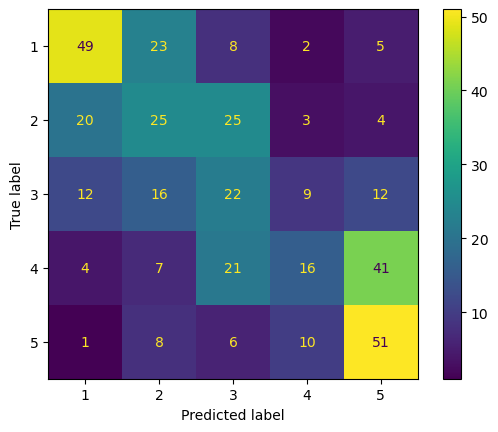

In [14]:
# Prepare data for LSTM model
X = np.stack(df_m17['embeddings'].values)
y = df_m17['evaluation'].values - 1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape data to fit LSTM input requirements
X_train = np.expand_dims(X_train, axis=1)  # Add a time dimension
X_test = np.expand_dims(X_test, axis=1)

# Build the expanded LSTM model
model = Sequential()
# First LSTM layer with Batch Normalization
model.add(LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Second LSTM layer
model.add(LSTM(64, return_sequences=False))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Dense layers
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(5, activation='softmax'))  # 5-class classification

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.002, restore_best_weights=True),
]
# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1, callbacks=callbacks)
# Train the model

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

y_pred = np.argmax(model.predict(X_test), axis=1)
y_pred = y_pred + 1
y_test = y_test + 1
display(f"LSTM with SciBERT embeddings Accuracy score: {accuracy_score(y_test, y_pred)}")
display(f"LSTM with SciBERT embeddings Recall score: {recall_score(y_test, y_pred, average='macro')}")
display(f"LSTM with SciBERT embeddings F1 score: {f1_score(y_test,  y_pred, average='macro')}")
display(f"LSTM with SciBERT embeddings Precision score: {precision_score(y_test, y_pred, average='macro')}")
display(f"LSTM with SciBERT embeddings MAE score: {mean_absolute_error(y_test, y_pred)}")
display(f"Multimodal Predictor MSE score: {mean_squared_error(y_test, y_pred)}")
get_conf_matrix(y_test=y_test, y_pred=y_pred)

Epoch 1/20


Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 6.9781 - mean_absolute_error: 2.1911 - val_loss: 8.5820 - val_mean_absolute_error: 2.5871
Epoch 2/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.9977 - mean_absolute_error: 1.3715 - val_loss: 8.0593 - val_mean_absolute_error: 2.5044
Epoch 3/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.4994 - mean_absolute_error: 1.2627 - val_loss: 7.1004 - val_mean_absolute_error: 2.3369
Epoch 4/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.0512 - mean_absolute_error: 1.1522 - val_loss: 5.9821 - val_mean_absolute_error: 2.1095
Epoch 5/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.9211 - mean_absolute_error: 1.0945 - val_loss: 5.4551 - val_mean_absolute_error: 1.9981
Epoch 6/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.9169 - mean_absolute_error: 1.0944 - val_loss: 4.3913 - val_mean_absolute_error: 1.7778
Epoch 7/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.9452 - mean_absolute_error: 1.0992 - val_loss: 3.5667 - val_mea

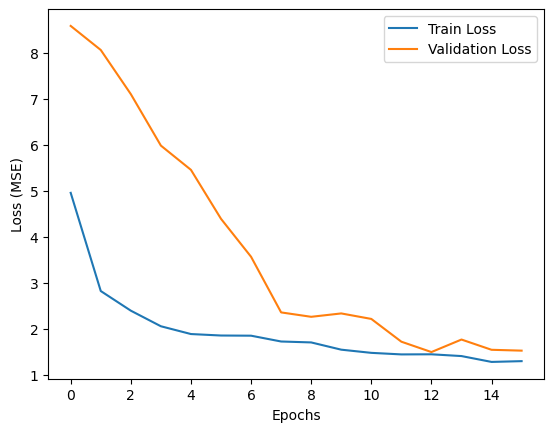

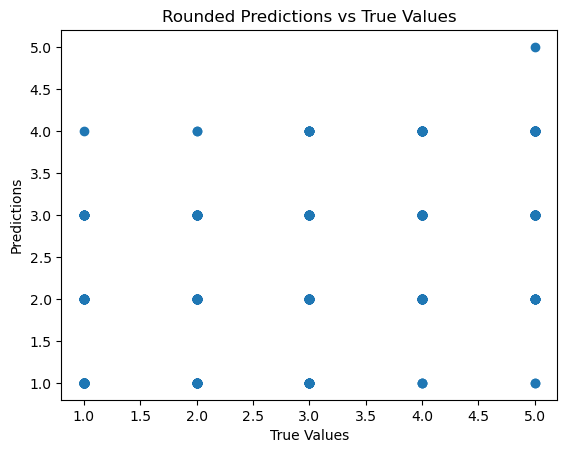

'LSTM with SciBERT embeddings Accuracy score: 0.3125'

'LSTM with SciBERT embeddings Recall score: 0.3050018547508042'

'LSTM with SciBERT embeddings F1 score: 0.2801592072369071'

'LSTM with SciBERT embeddings Precision score: 0.46216350568623293'

'LSTM with SciBERT embeddings MAE score: 0.995'

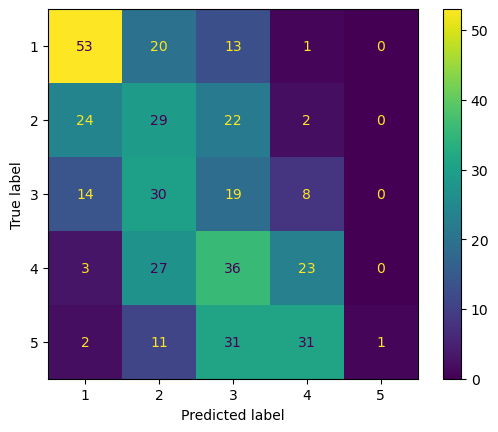

In [9]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import LSTM, BatchNormalization, Dropout, Dense
import keras.callbacks
import matplotlib.pyplot as plt

# Assuming df_m17 is your DataFrame containing the embeddings and evaluation columns
X = np.stack(df_m17['embeddings'].values)
y = df_m17['evaluation'].values  # Assuming evaluation values are continuous for regression

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape data to fit LSTM input requirements
X_train = np.expand_dims(X_train, axis=1)  # Add a time dimension
X_test = np.expand_dims(X_test, axis=1)

# Build the expanded LSTM model
model = Sequential()
# First LSTM layer with Batch Normalization
model.add(LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Second LSTM layer
model.add(LSTM(64, return_sequences=False))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Dense layers
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='linear'))  # Single output unit for regression

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])

callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.002, restore_best_weights=True),
]

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1, callbacks=callbacks)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f'Test Loss (MSE): {loss}')
print(f'Test Mean Absolute Error: {mae}')

# Make predictions
y_pred = model.predict(X_test)

# Round predictions to the nearest integer
y_pred_rounded = np.round(y_pred).astype(int)

# Metrics
mse = mean_squared_error(y_test, y_pred_rounded)
mae = mean_absolute_error(y_test, y_pred_rounded)
print(f'Mean Squared Error (rounded): {mse}')
print(f'Mean Absolute Error (rounded): {mae}')

# Plotting the training history
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()
# Plotting rounded predictions vs true values
plt.scatter(y_test, y_pred_rounded)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Rounded Predictions vs True Values')
plt.show()

y_pred = y_pred_rounded

display(f"LSTM with SciBERT embeddings Accuracy score: {accuracy_score(y_test, y_pred)}")
display(f"LSTM with SciBERT embeddings Recall score: {recall_score(y_test, y_pred, average='macro')}")
display(f"LSTM with SciBERT embeddings F1 score: {f1_score(y_test,  y_pred, average='macro')}")
display(f"LSTM with SciBERT embeddings Precision score: {precision_score(y_test, y_pred, average='macro')}")
display(f"LSTM with SciBERT embeddings MAE score: {mean_absolute_error(y_test, y_pred)}")
get_conf_matrix(y_test=y_test, y_pred=y_pred)

Epoch 1/20


Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5268 - loss: 0.8742 - val_accuracy: 0.6250 - val_loss: 0.6599
Epoch 2/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6014 - loss: 0.7442 - val_accuracy: 0.5625 - val_loss: 0.7165
Epoch 3/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6115 - loss: 0.7032 - val_accuracy: 0.6333 - val_loss: 0.6562
Epoch 4/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6308 - loss: 0.6605 - val_accuracy: 0.6417 - val_loss: 0.6696
Epoch 5/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6635 - loss: 0.6338 - val_accuracy: 0.6042 - val_loss: 0.6622
Epoch 6/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6515 - loss: 0.6320 - val_accuracy: 0.6458 - val_loss: 0.6326
Epoch 7/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6698 - loss: 0.6133 - val_accuracy: 0.6500 - val_loss: 0.6518
Epoch 8/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6900 - loss: 0.5883 - val_accuracy: 0.6292 - val_loss: 0.6629
Epo

'Multilayer Perceptron with TF-IDF Accuracy score: 0.625'

'Multilayer Perceptron with TF-IDF Recall score: 0.625402681945358'

'Multilayer Perceptron with TF-IDF F1 score: 0.6246987164696103'

'Multilayer Perceptron with TF-IDF Precision score: 0.625'

'Multilayer Perceptron with TF-IDF MAE score: 0.375'

'Multilayer Perceptron with TF-IDF MSE score: 0.375'

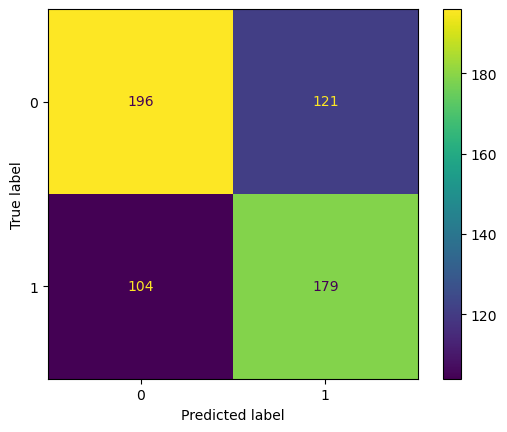

In [12]:
# Prepare data for LSTM model
X = np.stack(df_c19['embeddings'].values)
y = df_c19['cited'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = Sequential()

# First Dense layer with Batch Normalization
model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Second Dense layer
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))




# Third Dense layer
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Output layer for binary classification
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

# Make predictions
y_pred = (model.predict(X_test) > 0.5).astype(int)
print(f'Predictions: {y_pred.flatten()}')  # Predictions for binary classification

display(f"Multilayer Perceptron with TF-IDF Accuracy score: {accuracy_score(y_test, y_pred)}")
display(f"Multilayer Perceptron with TF-IDF Recall score: {recall_score(y_test, y_pred, average='macro')}")
display(f"Multilayer Perceptron with TF-IDF F1 score: {f1_score(y_test,  y_pred, average='macro')}")
display(f"Multilayer Perceptron with TF-IDF Precision score: {precision_score(y_test, y_pred, average='macro')}")
display(f"Multilayer Perceptron with TF-IDF MAE score: {mean_absolute_error(y_test, y_pred)}")
# display(f"Multilayer Perceptron with TF-IDF RMSE score: {root_mean_squared_error(y_test, y_pred)}")
display(f"Multilayer Perceptron with TF-IDF MSE score: {mean_squared_error(y_test, y_pred)}")
get_conf_matrix(y_test=y_test, y_pred=y_pred)

Epoch 1/30


Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 2.1950 - sparse_categorical_accuracy: 0.2399 - val_loss: 1.3615 - val_sparse_categorical_accuracy: 0.3688
Epoch 2/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7195 - sparse_categorical_accuracy: 0.3389 - val_loss: 1.3453 - val_sparse_categorical_accuracy: 0.3625
Epoch 3/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4998 - sparse_categorical_accuracy: 0.3881 - val_loss: 1.2823 - val_sparse_categorical_accuracy: 0.4250
Epoch 4/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4131 - sparse_categorical_accuracy: 0.3994 - val_loss: 1.2906 - val_sparse_categorical_accuracy: 0.4000
Epoch 5/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3959 - sparse_categorical_accuracy: 0.4273 - val_loss: 1.2852 - val_sparse_categorical_accuracy: 0.4187
Epoch 6/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3156 - sparse_categorical_accuracy: 0.4516 - val_loss: 1.2942 - val_sparse_categorical_accuracy: 0.3688
Epoch 7/30
45/45 ━━━━━━━━━━

'Multilayer Perceptron with TF-IDF Accuracy score: 0.395'

'Multilayer Perceptron with TF-IDF Recall score: 0.38344663233518583'

'Multilayer Perceptron with TF-IDF F1 score: 0.3722177269428122'

'Multilayer Perceptron with TF-IDF Precision score: 0.37932494588744586'

'Multilayer Perceptron with TF-IDF MAE score: 0.925'

'Multilayer Perceptron with TF-IDF MSE score: 1.78'

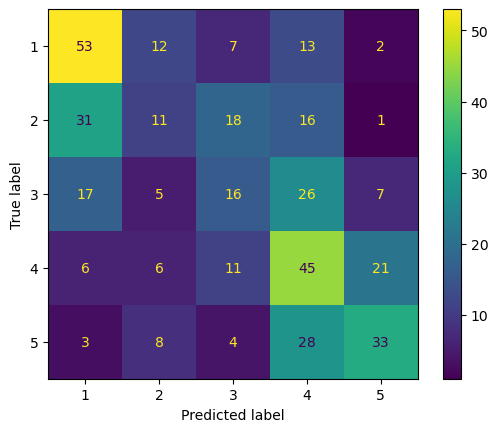

In [10]:
# Split the data into training and testing sets
# Assuming df_m17 is your DataFrame containing the embeddings and evaluation columns
X = np.stack(df_m17['embeddings'].values)
y = df_m17['evaluation'].values  # Assuming evaluation values are continuous for regression
y = y - 1
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the neural network model
model = Sequential()

# First Dense layer with Batch Normalization
model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Second Dense layer
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Output layer for 5-class classification
model.add(Dense(5, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['sparse_categorical_accuracy'])
callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, min_delta=0.002, restore_best_weights=True),
]
# Train the model
model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.1, callbacks=callbacks)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

y_pred = np.argmax(model.predict(X_test), axis=1)
y_pred = y_pred + 1
y_test = y_test + 1
display(f"Multilayer Perceptron with TF-IDF Accuracy score: {accuracy_score(y_test, y_pred)}")
display(f"Multilayer Perceptron with TF-IDF Recall score: {recall_score(y_test, y_pred, average='macro')}")
display(f"Multilayer Perceptron with TF-IDF F1 score: {f1_score(y_test,  y_pred, average='macro')}")
display(f"Multilayer Perceptron with TF-IDF Precision score: {precision_score(y_test, y_pred, average='macro')}")
display(f"Multilayer Perceptron with TF-IDF MAE score: {mean_absolute_error(y_test, y_pred)}")
# display(f"Multilayer Perceptron with TF-IDF RMSE score: {root_mean_squared_error(y_test, y_pred)}")
display(f"Multilayer Perceptron with TF-IDF MSE score: {mean_squared_error(y_test, y_pred)}")
get_conf_matrix(y_test=y_test, y_pred=y_pred)